In [1]:
import tensorflow as tf
import numpy as np

In [3]:
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
print(train_X.shape, train_Y.shape)

train_X = train_X / 255.0
test_X = test_X / 255.0

(60000, 28, 28) (60000,)


In [4]:
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), activation='elu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), activation='elu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(7*7*64, activation='elu'),
    tf.keras.layers.Reshape(target_shape=(7,7,64)),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2,2),
                                    padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=(2,2),
                                    padding='same', activation='sigmoid'),
])

In [5]:
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                100416    
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        8

In [6]:
# 잠재변수 벡터 확보
latent_vector_model = tf.keras.Model(inputs=model.input, outputs=model.layers[3].output)
latent_vector = latent_vector_model.predict(train_X)
print(latent_vector.shape)
print(latent_vector[0])

(60000, 64)
[ 0.1717985  -0.05724931  0.05127063  0.04157808 -0.05018318  0.06485614
 -0.10182089 -0.0518167   0.04479678 -0.06180638 -0.0410701  -0.10061884
  0.11101343  0.0352473  -0.10620308  0.04538051  0.00582489  0.02892157
  0.04090525  0.05663483  0.020407    0.28175545 -0.01383322  0.01101675
  0.15065494 -0.12423408 -0.00963914 -0.04482621 -0.11674106  0.00183582
  0.02593314 -0.10896051 -0.13637161 -0.01421934  0.1800982  -0.11136621
 -0.09597749  0.10143594 -0.17137301  0.0012457  -0.15500772 -0.09963715
 -0.05899113  0.01147218  0.13375744 -0.24160361  0.04870159  0.00870135
 -0.20526409 -0.02312917  0.12762314 -0.08824682 -0.09395945  0.03936652
  0.06913729  0.06420568 -0.06941354  0.01158157  0.17515866  0.06441584
 -0.07695156 -0.08337975  0.05184431 -0.05826515]


In [7]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(latent_vector)

CPU times: user 16.8 s, sys: 3.13 s, total: 19.9 s
Wall time: 2.88 s


KMeans(n_clusters=10, random_state=42)

In [8]:
print(kmeans.labels_)
print(kmeans.cluster_centers_.shape)
print(kmeans.cluster_centers_[0])

[4 8 7 ... 4 0 3]
(10, 64)
[ 0.10823774  0.05006602  0.03658117  0.11051984 -0.01528882  0.06468174
 -0.19599076  0.03870137  0.0242835  -0.03500825  0.03828058 -0.15320301
 -0.01500094 -0.00119275  0.04533681  0.008914   -0.11322555  0.07658972
 -0.00057955  0.0448849   0.0456344   0.11420217 -0.07367765  0.04861095
  0.01791189 -0.06648247 -0.0279786  -0.04985479 -0.10652059  0.04011631
 -0.01374597 -0.11140783 -0.00416007 -0.06275246  0.11213709 -0.11312152
 -0.02510199 -0.05613738 -0.02630193 -0.0833099  -0.05029783 -0.11734432
 -0.00915375  0.16521402  0.05430546 -0.1572215  -0.11338545 -0.07755192
 -0.06845179 -0.13280985 -0.00789526 -0.17463478 -0.0893635   0.10826189
 -0.00121125  0.09221104 -0.00426697 -0.02106725  0.08304983  0.2244465
 -0.12558156  0.05716105 -0.07236567 -0.11172841]


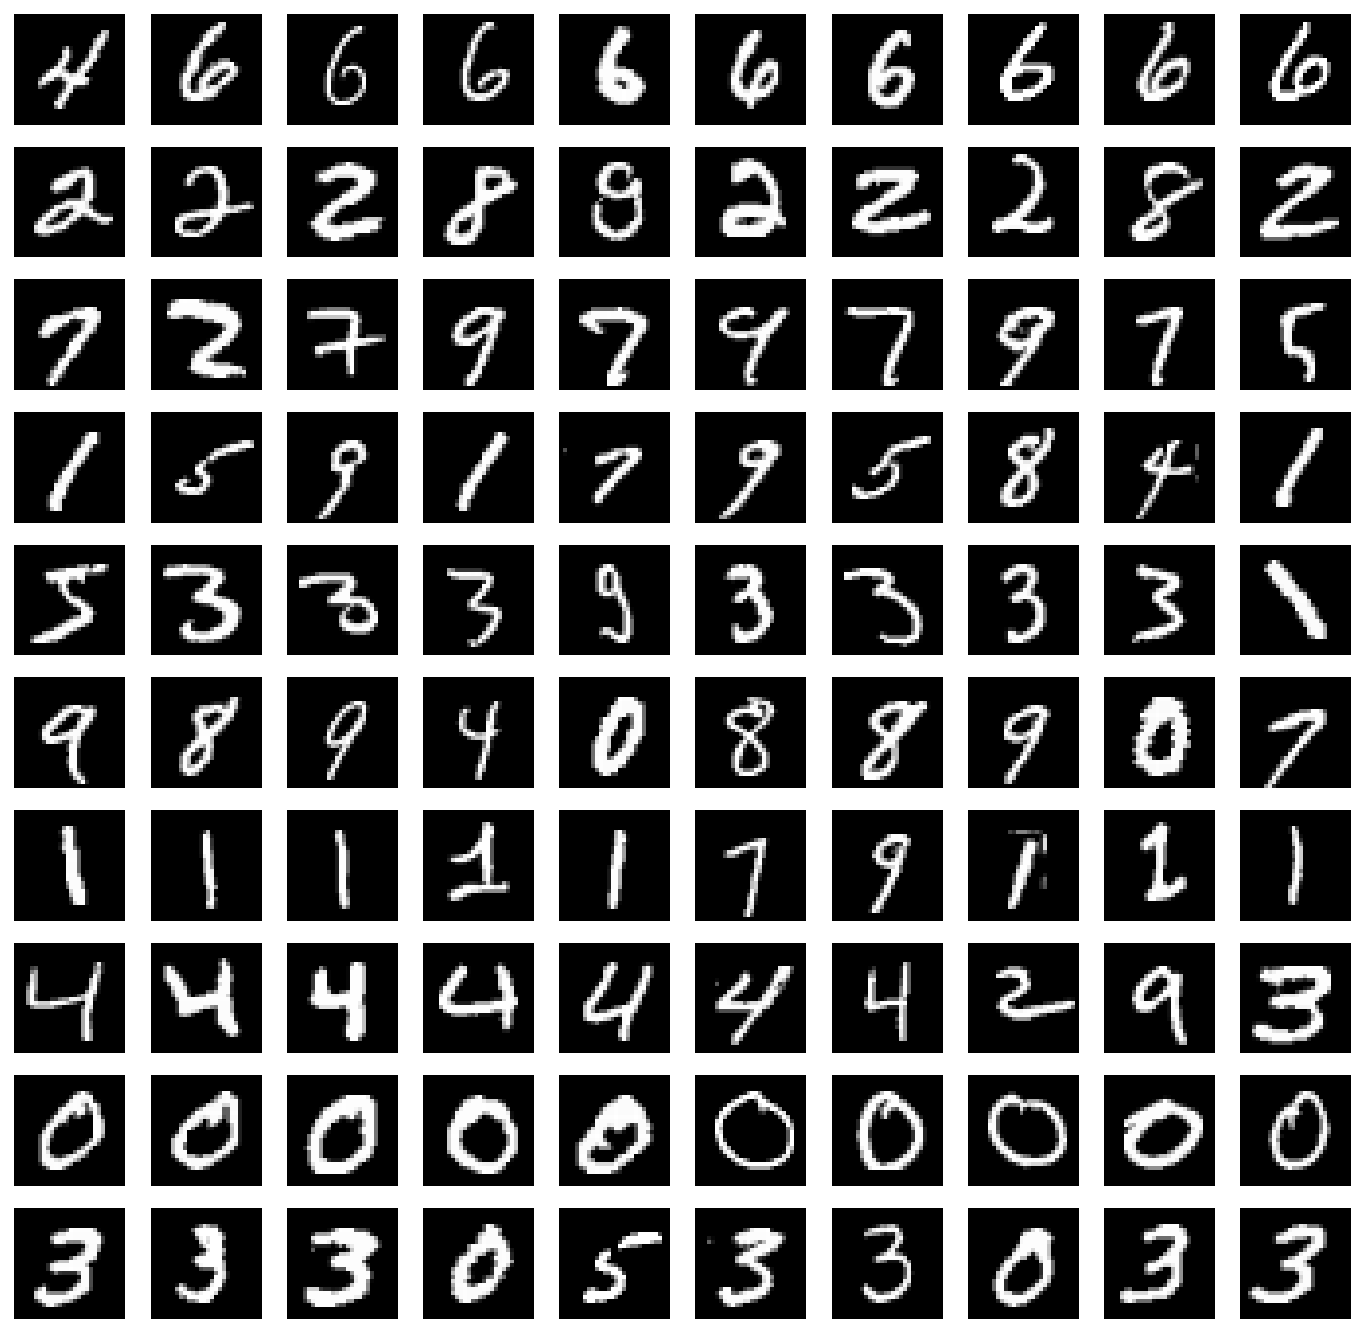

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))

for i in range(10):
    images = train_X[kmeans.labels_ == i]
    for c in range(10):
        plt.subplot(10, 10, i*10+c+1)
        plt.imshow(images[c].reshape(28, 28), cmap='gray')
        plt.axis('off')

plt.show()

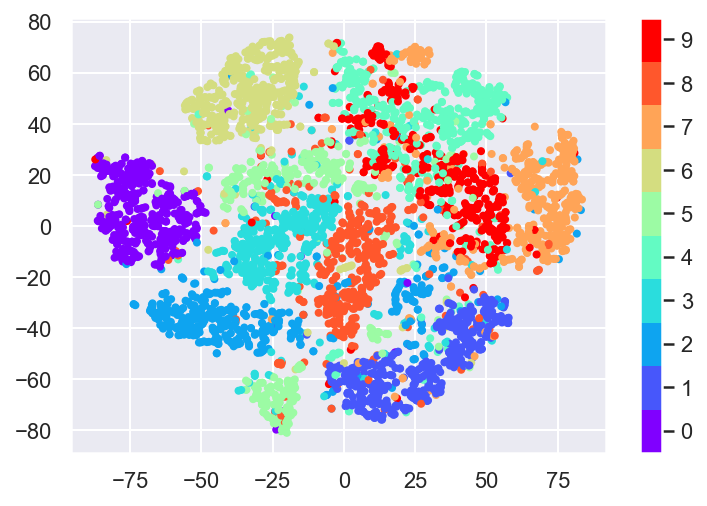

CPU times: user 1min 38s, sys: 2.82 s, total: 1min 41s
Wall time: 16.7 s


In [11]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
tsne_vector = tsne.fit_transform(latent_vector[:5000])

cmap = plt.get_cmap('rainbow', 10)
fig = plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=train_Y[:5000], cmap=cmap)
cb = plt.colorbar(fig, ticks=range(10))
n_clusters = 10
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cb.set_ticks(tick_locs)
cb.set_ticklabels(range(10))

plt.show()

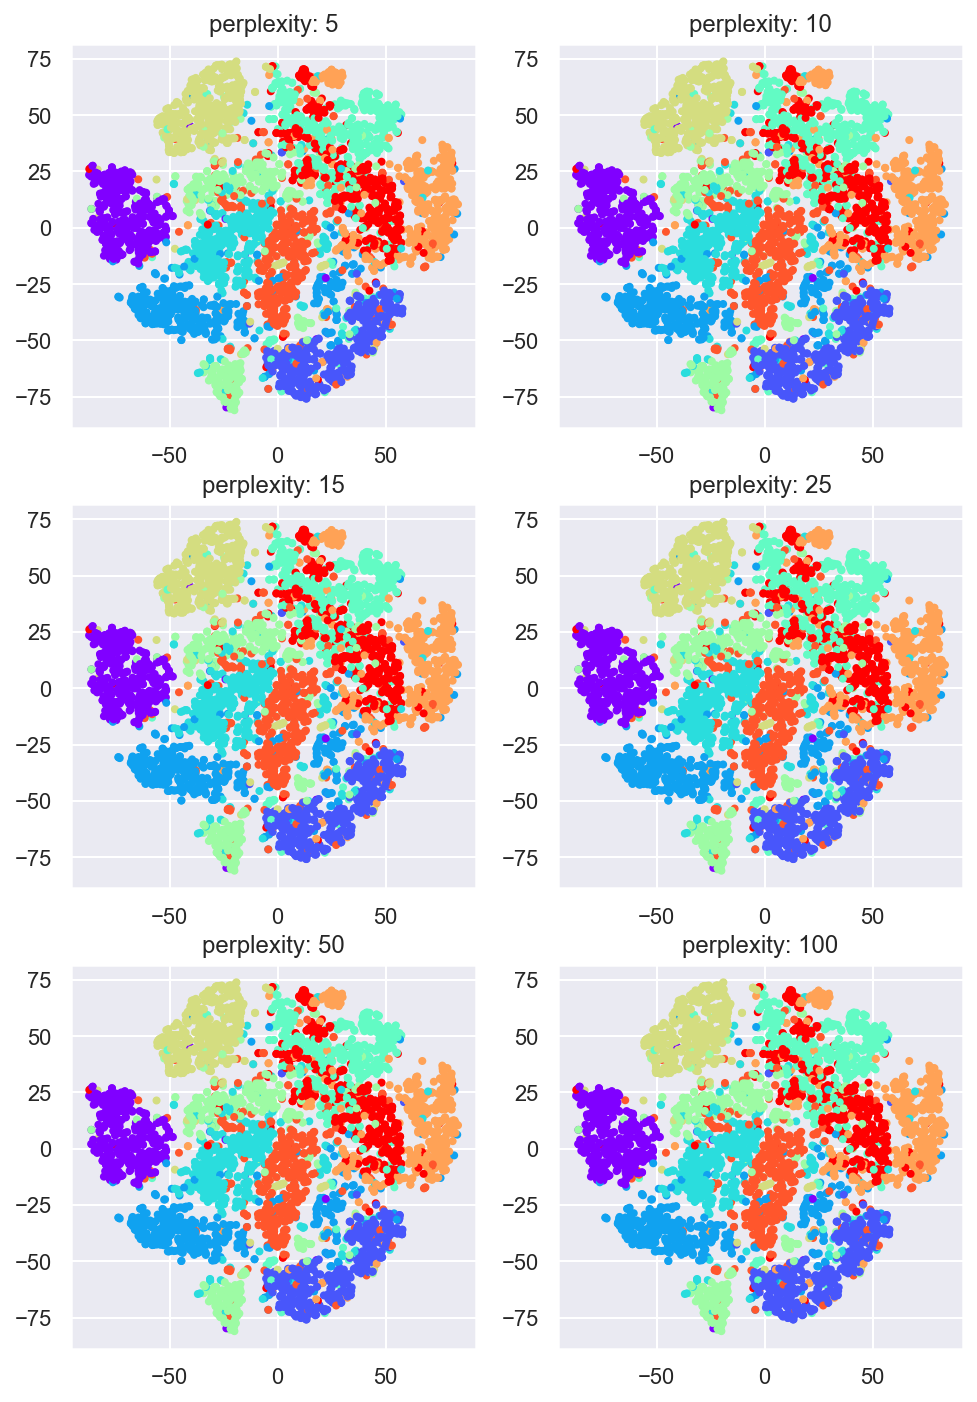

CPU times: user 9min 50s, sys: 16.3 s, total: 10min 6s
Wall time: 1min 39s


In [13]:
%%time

perplexities = [5, 10, 15, 25, 50, 100]
plt.figure(figsize=(8, 12))

for c in range(6):
    tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
    tsne_vector = tsne.fit_transform(latent_vector[:5000])
    
    plt.subplot(3, 2, c+1)
    plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=train_Y[:5000], cmap='rainbow')
    plt.title('perplexity: {0}'.format(perplexities[c]))
    
plt.show()

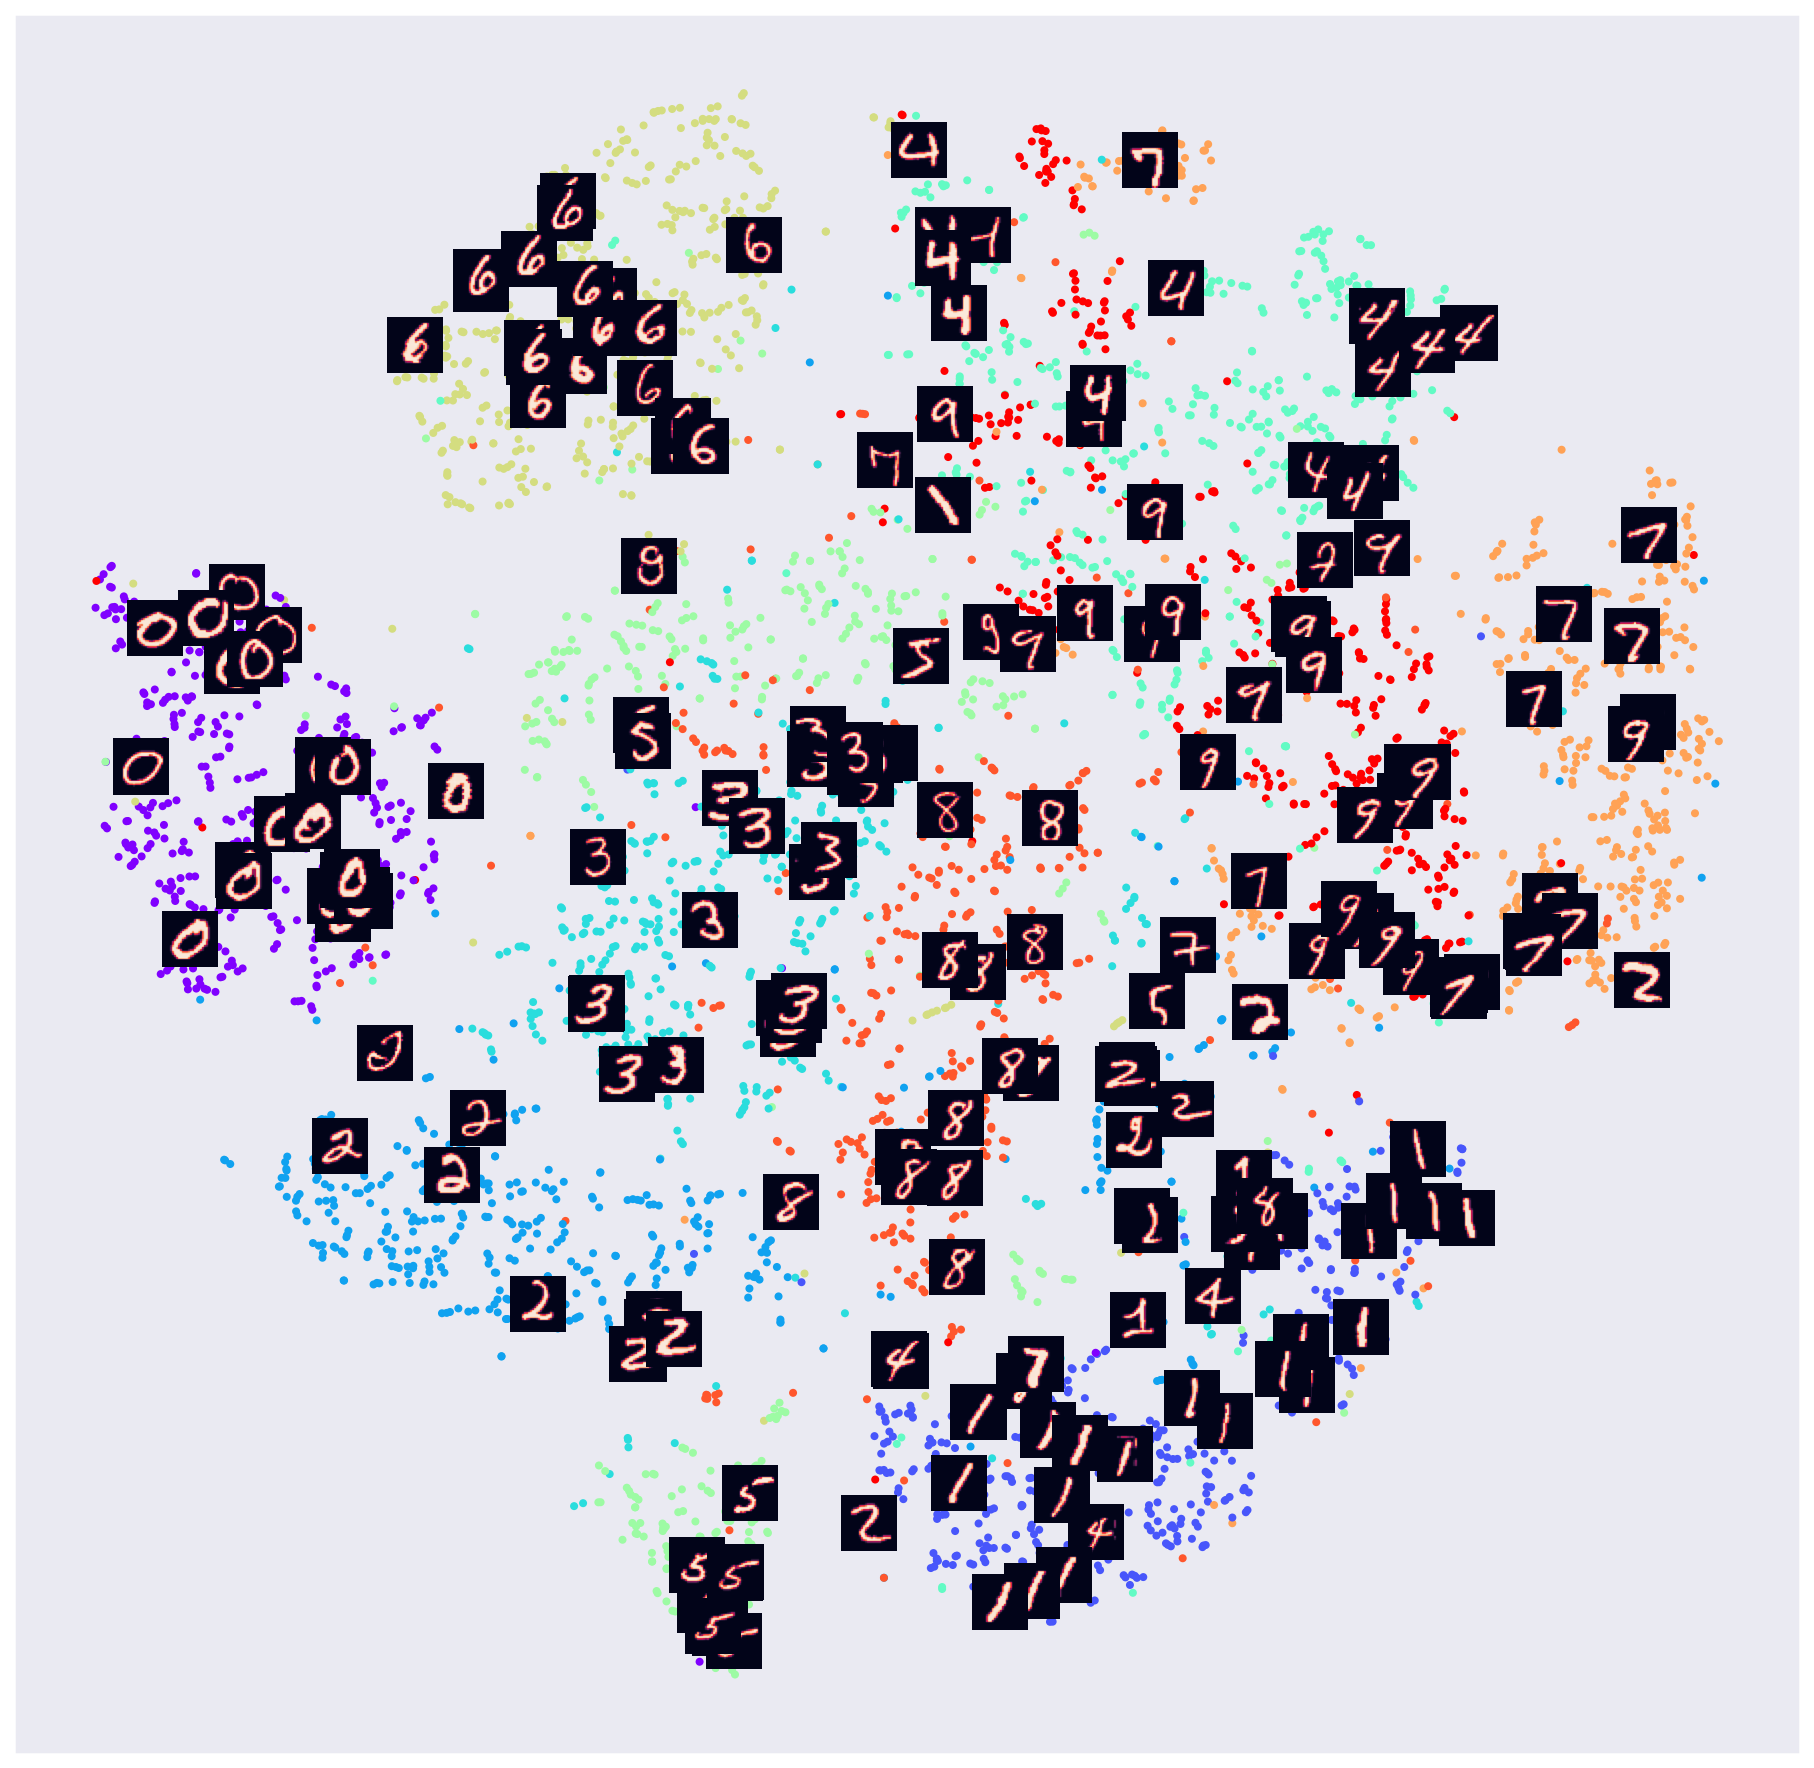

In [17]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

plt.figure(figsize=(16, 16))

tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
tsne_vector = tsne.fit_transform(latent_vector[:5000])

ax = plt.subplot(1, 1, 1)
ax.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=train_Y[:5000], cmap='rainbow')

for i in range(200):
    imagebox = OffsetImage(train_X[i].reshape(28,28))
    ab = AnnotationBbox(imagebox, (tsne_vector[i,0], tsne_vector[i,1]), frameon=False, pad=0.0)
    ax.add_artist(ab)

ax.set_xticks([])
ax.set_yticks([])
plt.show()